In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from conditional_GAN import Generator, Discriminator, generator_loss, discriminator_loss

/workspace/qing/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "../mnist/cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = torch.from_numpy(np.load(path + "colored_mnist_init_train.npy"))
mnist_test = torch.from_numpy(np.load(path + "colored_mnist_init_test.npy"))
mnist_train_target = torch.from_numpy(np.load(path + "colored_mnist_target_train.npy"))
mnist_test_target = torch.from_numpy(np.load(path + "colored_mnist_target_test.npy"))

print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

batch_size = 128
train_dataset = TensorDataset(mnist_train, mnist_train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(mnist_test, mnist_test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

torch.Size([60000, 3, 28, 28]) torch.Size([10000, 3, 28, 28])
torch.Size([60000, 7]) torch.Size([10000, 7])


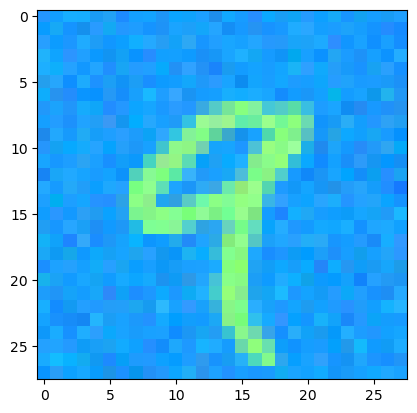

In [3]:
plt.imshow(mnist_train[4].permute(1, 2, 0))
plt.show()

In [4]:
torch.manual_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

latent_dim = 128
generator = Generator(latent_dim=latent_dim, label_dim=7)
generator.to(device)
discriminator = Discriminator(label_dim=7)
discriminator.to(device)

G_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
D_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

Selected device: cuda


In [7]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    generator.train()
    discriminator.train()
    average_D_loss, average_G_loss = 0, 0

    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        real_images = real_images.to(device)
        labels = labels.to(device)

        real_target = Variable(torch.ones(real_images.shape[0], device=device))
        fake_target = Variable(torch.zeros(real_images.shape[0], device=device))

        D_real_loss = discriminator_loss(
            discriminator(real_images, labels), real_target
        )

        noise_vector = torch.randn(real_images.shape[0], latent_dim, 1, 1, device=device)
        fake_labels = Variable(torch.randint(0, 9, (labels.shape[0], 7), device=device, dtype=torch.float))

        generated_image = generator(noise_vector, labels)
        output = discriminator(generated_image.detach(), fake_labels)
        D_fake_loss = discriminator_loss(output, fake_target)

        D_total_loss = (D_real_loss + D_fake_loss)
        average_D_loss += D_total_loss.item()

        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_loss = generator_loss(discriminator(generated_image, fake_labels), real_target)
        average_G_loss += G_loss.item()

        G_loss.backward()
        G_optimizer.step()

    average_G_loss = average_G_loss / len(train_loader)
    average_D_loss = average_D_loss / len(train_loader)
    print(
        "Generator loss: {}, Discriminator loss: {}".format(
            average_G_loss, average_D_loss
        )
    )

Generator loss: 11.993556381542799, Discriminator loss: 0.0065192697980695396
Generator loss: 13.472642823323003, Discriminator loss: 1.5995110385189726e-05
Generator loss: 14.077028339605596, Discriminator loss: 6.122809661408063e-06
Generator loss: 14.659864765240439, Discriminator loss: 3.130502175897138e-06
Generator loss: 15.187331925577192, Discriminator loss: 1.6507026822882584e-06
Generator loss: 15.640539364519912, Discriminator loss: 9.566222028974277e-07
Generator loss: 15.808340099066305, Discriminator loss: 7.3504693111428e-07
Generator loss: 16.186379093096964, Discriminator loss: 5.592414615774086e-07
Generator loss: 16.540191453148815, Discriminator loss: 3.927532136729958e-07
Generator loss: 16.869134351897088, Discriminator loss: 2.8318015741468945e-07


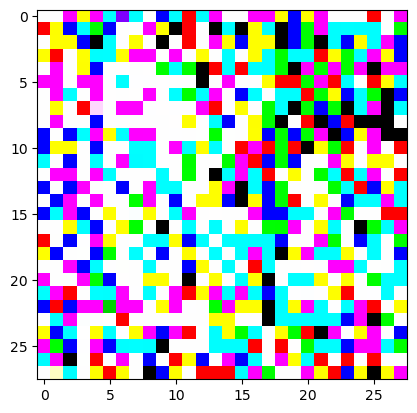

In [9]:
generator.eval()
with torch.no_grad():
    noise_vector = torch.randn(1, latent_dim, 1, 1, device=device)
    generated_image = generator(
        noise_vector, mnist_train_target[0, :].unsqueeze(0).to(device)
    )
    plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0))